<a href="https://colab.research.google.com/github/ozgunhaznedar/Hurricane-Damage-Detector---Image-Recognition/blob/main/Hurricane_Damage_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hurricane Damage Detector

## Get and Load Dataset and Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential , Model

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

tf.random.set_seed(42)

print('TF Version:', tf.__version__)

TF Version: 2.8.0


In [2]:
# download the images and unzip
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1CtOsyMzWr8jyQIwkiPULkdMUPgTR19a-
!unzip -q hurricane_detector.zip

In [3]:
%%capture
!sudo apt-get install tree

In [4]:
!tree --dirsfirst --filelimit 2 ./train_another/ #training set number of images

./train_another/
├── damage [5000 entries exceeds filelimit, not opening dir]
└── no_damage [5000 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [5]:
!tree --dirsfirst --filelimit 2 ./validation_another/  #validation set number of images

./validation_another/
├── damage [1000 entries exceeds filelimit, not opening dir]
└── no_damage [1000 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [6]:
!tree --dirsfirst --filelimit 2 ./test/ #test set number of images

./test/
├── damage [1000 entries exceeds filelimit, not opening dir]
└── no_damage [1000 entries exceeds filelimit, not opening dir]

2 directories, 0 files


In [7]:
!tree --dirsfirst --filelimit 2 ./test_another/  #second test set number of images

./test_another/
├── damage [8000 entries exceeds filelimit, not opening dir]
└── no_damage [1000 entries exceeds filelimit, not opening dir]

2 directories, 0 files


## Utility functions to create dataset generators

In [8]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./train_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./validation_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test_1(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

def eval_model_on_test_2(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./test_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions



## Creating datasets using the dataset generator function

In [9]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


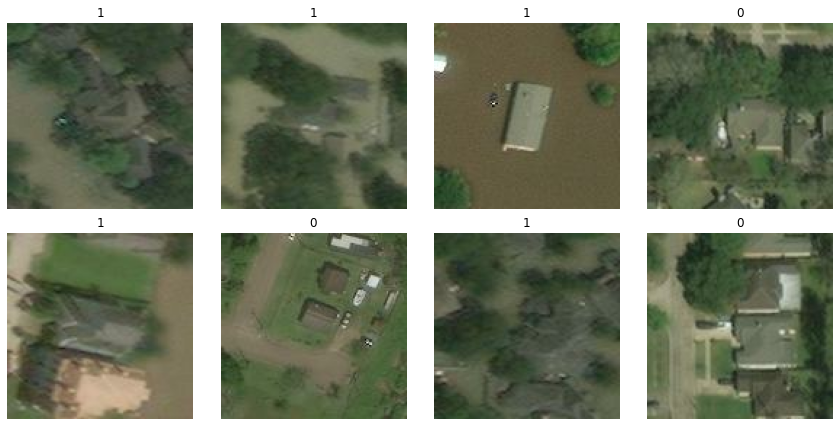

In [10]:
plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

## Apply data augmentation operations on the train dataset

Go to the `prepare_train_and_val_datasets(...)` and you can add augmentation operations directly to the train dataset as follows:


Remember to check [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image#image_adjustments) for various image transforms available and you can play around with augmentations

__Be careful here and don't add too many transforms which can distort the images beyond recognition__

In [11]:
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

## Function to visualize the loss and accuracy in training and validation sets

In [12]:
# this function plots 2 graphs. First one plots loss value per epoch; second one accuracy per epoch.
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

## Function to show confusion matrix and classification report on the test data.

In [13]:
# dictionary to store model results
results = dict()

# this function prints the confusion matrix and classification report on the test data
def test_conf_report(model , model_name,LR):
  test_labels1, predictions1 = eval_model_on_test_1(model)
  test_labels2, predictions2 = eval_model_on_test_2(model)
  predictions1 = np.where(predictions1 > 0.5, 1, 0)
  predictions2 = np.where(predictions2 > 0.5, 1, 0)
  cm1 = confusion_matrix(test_labels1, predictions1)
  cm2 = confusion_matrix(test_labels2, predictions2)
  print("Classification Report on Test Data 1")
  print(classification_report(test_labels1, predictions1))
  print()
  print("Confusion Matrix on Test Data 1")
  print(pd.DataFrame(cm1))

  #storing the results to a dictionary
  accuracy1 = round((cm1[0,0] + cm1[1,1]) / np.sum(cm1),3)
  accuracy2 = round((cm2[0,0] + cm2[1,1]) / np.sum(cm2),3)
  results[model_name] = [accuracy1,accuracy2,LR] 
  return results

# Base CNN Model

## Model Building

**Start with a simple baseline model to get a becnhmark performance to build on. Looking at the results of this model, try to get better accuracy with changing hyperparameters and trying different models.**

In [14]:
#start with a learning rate of 0.0001
model_name = "Baseline_CNN"
LR = 0.0001
epochs=100

#define a callback on the validation dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)

In [15]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

#compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=epochs,
  verbose=0
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

## Results on validation and test data

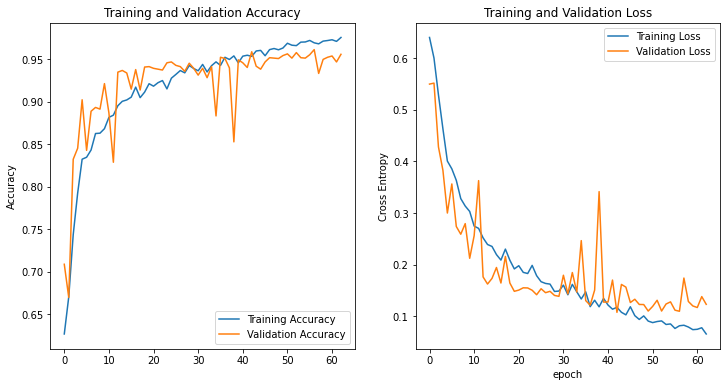


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:01<00:00,  9.29it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:05<00:00, 11.93it/s]


Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1000
           1       0.98      0.95      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000


Confusion Matrix on Test Data 1
     0    1
0  981   19
1   45  955


{'Baseline_CNN': [0.968, 0.951, 0.0001]}

In [16]:
plot_loss_acc(history)
print()
test_conf_report(model , model_name,LR)

**There may be some overfitting of the model to the training set. This is visible after about epoch number 30 in the above graphs. 
Next, try the same model with adding a dropout of 20%.**



# CNN with dropout

## Model Building

In [17]:
model_name = "CNN w/ Dropout"
LR = 0.0001
epochs=100


model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

#compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=epochs,
  verbose=0
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)       

## Results on validation and test data

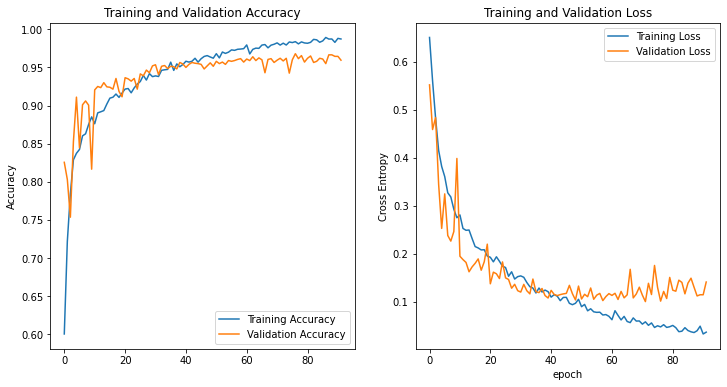


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:01<00:00, 10.51it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:05<00:00, 12.09it/s]

Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1000
           1       0.99      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix on Test Data 1
     0    1
0  988   12
1   34  966


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001]}

In [18]:
plot_loss_acc(history)
print()
test_conf_report(model , model_name,LR)

# Resnet 50

## Model Building

** After setting our benchmark with our base model, try transfer learning by using pre-trained models. **

In [19]:
model_name = "RESNET 50"
LR = 0.0001
initial_epoch = 30


base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=(128,128, 3))
#x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)  # important: training=False
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=initial_epoch,
  verbose=0
)


94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                              

## Results on validation and test data

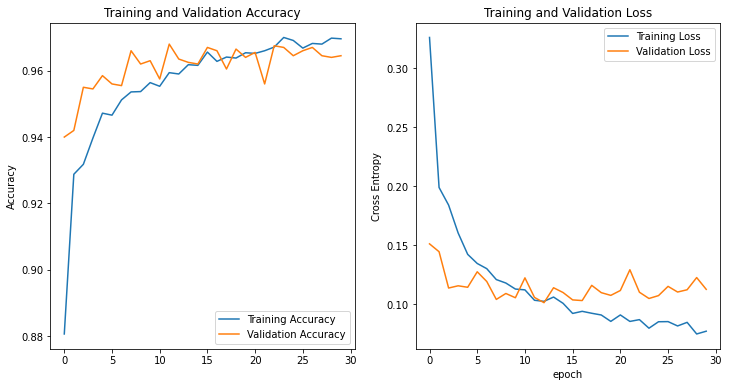


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:11<00:00,  6.14it/s]


Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Confusion Matrix on Test Data 1
     0    1
0  981   19
1   30  970


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'RESNET 50': [0.976, 0.961, 0.0001]}

In [20]:
plot_loss_acc(history)
print()
test_conf_report(model , model_name,LR)

# Restnet 50 Tunning

## Model Building

In [21]:
model_name = "RESNET 50 Tuned"
LR = 0.0001/10
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs


base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  initial_epoch = history.epoch[-1],
  epochs=total_epochs,
  verbose=0
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 256)               524544

## Results on validation and test data

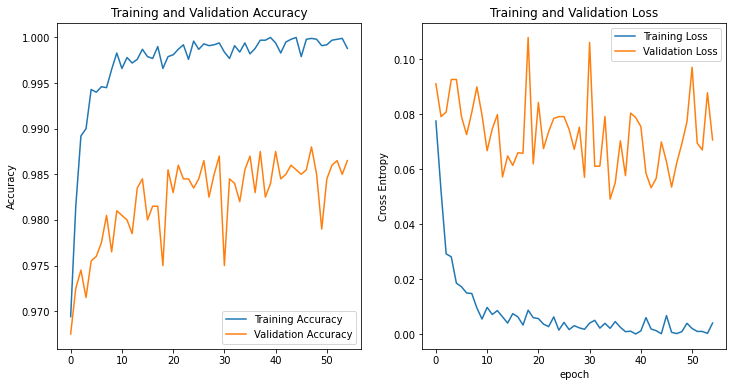


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:11<00:00,  6.17it/s]

Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Confusion Matrix on Test Data 1
     0    1
0  995    5
1    9  991


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'RESNET 50': [0.976, 0.961, 0.0001],
 'RESNET 50 Tuned': [0.993, 0.986, 1e-05]}

In [22]:
plot_loss_acc(history2)
print()
test_conf_report(model , model_name,LR)

# Resnet 50 Tunning and Decaying Learning Rate

## Model Building

In [23]:
model_name = "RESNET 50 Tuned w/ Decay LR"
initial_learning_rate =  0.00001
final_learning_rate = initial_learning_rate/10
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/fine_tune_epochs)
steps_per_epoch = int(10000/32)  #train size / batch size

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=total_epochs,
  initial_epoch = history.epoch[-1],
  verbose=0
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 256)               524544

## Results on validation and test data

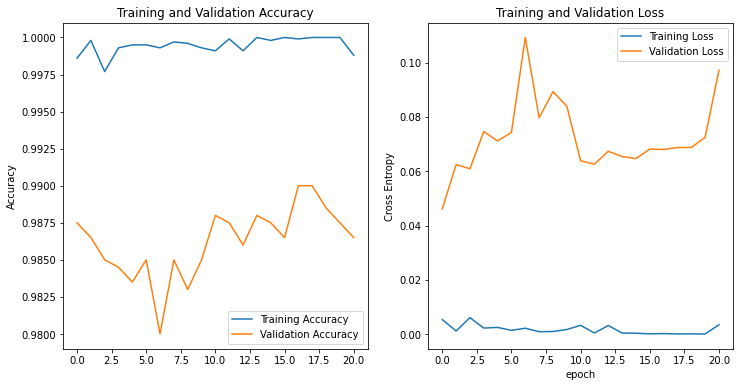


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:11<00:00,  6.15it/s]

Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1000
           1       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000


Confusion Matrix on Test Data 1
     0    1
0  995    5
1   12  988


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'RESNET 50': [0.976, 0.961, 0.0001],
 'RESNET 50 Tuned': [0.993, 0.986, 1e-05],
 'RESNET 50 Tuned w/ Decay LR': [0.992, 0.983, 1e-05]}

In [24]:
plot_loss_acc(history2)
print()
test_conf_report(model , model_name,LR)

# Mobile Net Model

## Model Building

In [25]:
model_name = "MOBILE NET"
LR = 0.0001
initial_epoch = 50

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=initial_epoch,
  verbose=0
)


9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0      

## Results on validation and test data

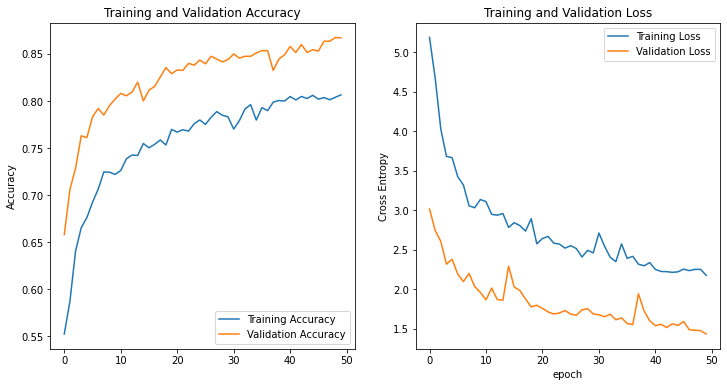


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:08<00:00,  8.37it/s]

Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1000
           1       0.86      0.84      0.85      1000

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000


Confusion Matrix on Test Data 1
     0    1
0  861  139
1  156  844


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'MOBILE NET': [0.852, 0.857, 0.0001],
 'RESNET 50': [0.976, 0.961, 0.0001],
 'RESNET 50 Tuned': [0.993, 0.986, 1e-05],
 'RESNET 50 Tuned w/ Decay LR': [0.992, 0.983, 1e-05]}

In [26]:
plot_loss_acc(history)
print()
test_conf_report(model , model_name,LR)

# Mobile Net Model Tunning

## Model Building

In [27]:
model_name = "MOBILE NET Tuned"
LR = 0.0001/10
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs


base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  initial_epoch = history.epoch[-1],
  epochs=total_epochs,
  verbose=0
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

## Results on validation and test data

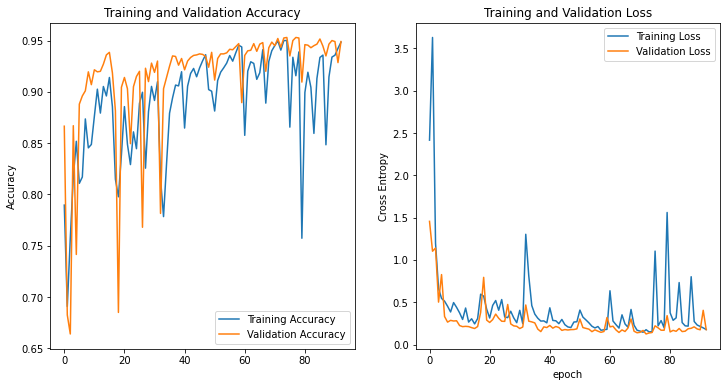


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:03<00:00,  5.08it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:08<00:00,  8.83it/s]


Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      1000
           1       0.97      0.92      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000


Confusion Matrix on Test Data 1
     0    1
0  972   28
1   79  921


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'MOBILE NET': [0.852, 0.857, 0.0001],
 'MOBILE NET Tuned': [0.946, 0.937, 1e-05],
 'RESNET 50': [0.976, 0.961, 0.0001],
 'RESNET 50 Tuned': [0.993, 0.986, 1e-05],
 'RESNET 50 Tuned w/ Decay LR': [0.992, 0.983, 1e-05]}

In [28]:
plot_loss_acc(history2)
print()
test_conf_report(model , model_name,LR)

# Mobile Net Model Tunnning and Decaying Learning Rate

## Model Building

In [29]:
model_name = "MOBILE NET Tuned w/ Decay LR"
fine_tune_epochs = 100
total_epochs =  initial_epoch + fine_tune_epochs
initial_learning_rate =  0.00001
final_learning_rate = initial_learning_rate/10
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/fine_tune_epochs)
steps_per_epoch = int(10000/32)  #train size / batch size

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history2 = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=total_epochs,
  initial_epoch = history.epoch[-1],
  verbose=0
)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

## Results on validation and test data

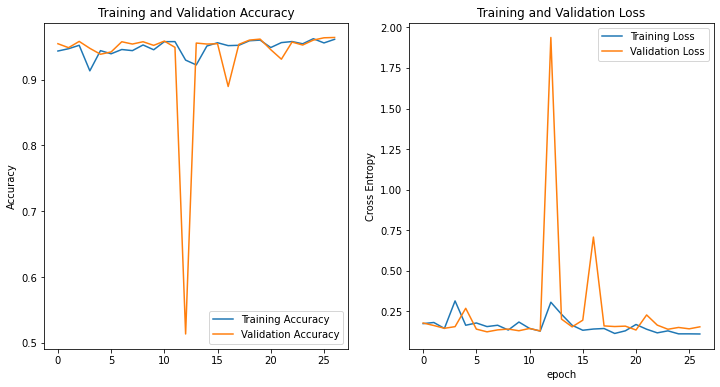


Found 2000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]


Found 9000 files belonging to 2 classes.


Predicting on Test Data: 100%|██████████| 71/71 [00:08<00:00,  8.84it/s]


Classification Report on Test Data 1
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1000
           1       0.97      0.95      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000


Confusion Matrix on Test Data 1
     0    1
0  967   33
1   50  950


{'Baseline_CNN': [0.968, 0.951, 0.0001],
 'CNN w/ Dropout': [0.977, 0.954, 0.0001],
 'MOBILE NET': [0.852, 0.857, 0.0001],
 'MOBILE NET Tuned': [0.946, 0.937, 1e-05],
 'MOBILE NET Tuned w/ Decay LR': [0.958, 0.953, 1e-05],
 'RESNET 50': [0.976, 0.961, 0.0001],
 'RESNET 50 Tuned': [0.993, 0.986, 1e-05],
 'RESNET 50 Tuned w/ Decay LR': [0.992, 0.983, 1e-05]}

In [30]:
plot_loss_acc(history2)
print()
test_conf_report(model , model_name,LR)

# Results - Comparision of Models

In [31]:
df = pd.DataFrame(results)
df = df.T 
df.rename(columns={0: "accuracy1", 1: "accuracy2",2:"LR"}).sort_values(by="accuracy1",ascending=False)

,accuracy1,accuracy2,LR
RESNET 50 Tuned,0.993,0.986,0.00001
RESNET 50 Tuned w/ Decay LR,0.992,0.983,0.00001
CNN w/ Dropout,0.977,0.954,0.00010
RESNET 50,0.976,0.961,0.00010
Baseline_CNN,0.968,0.951,0.00010
MOBILE NET Tuned w/ Decay LR,0.958,0.953,0.00001
MOBILE NET Tuned,0.946,0.937,0.00001
MOBILE NET,0.852,0.857,0.00010
